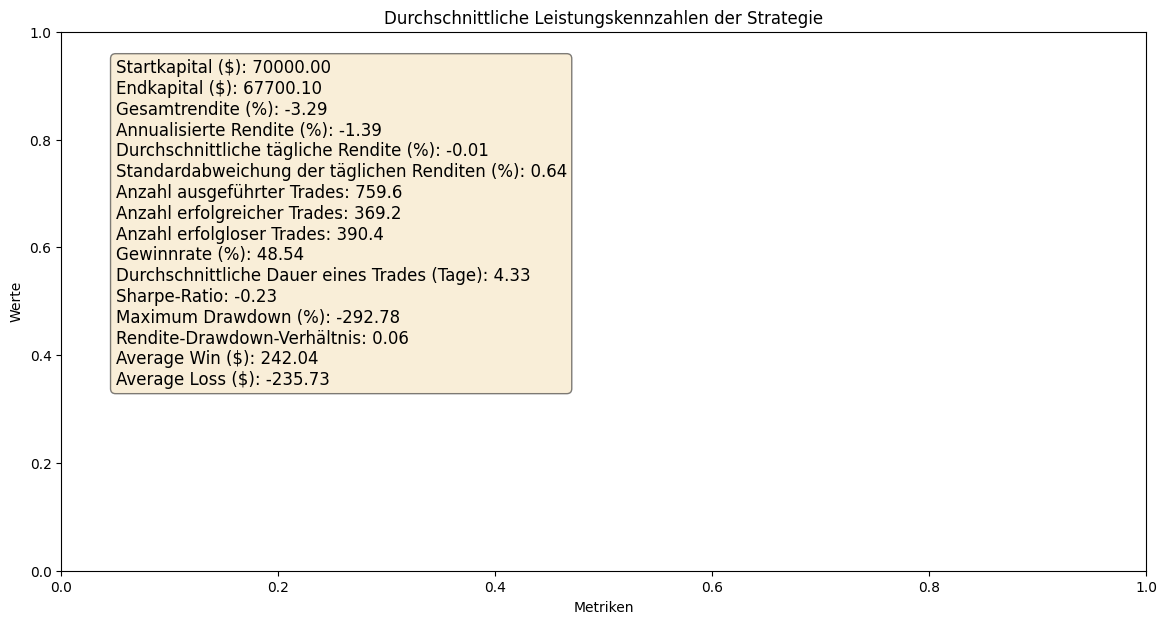

Durchschnittliche Kennzahlen für alle Iterationen:
Startkapital ($): 70000.0
Endkapital ($): 67700.10359871323
Gesamtrendite (%): -3.2855662875525224
Annualisierte Rendite (%): -1.385524372862387
Durchschnittliche tägliche Rendite (%): -0.00610805325941377
Standardabweichung der täglichen Renditen (%): 0.6360816593534908
Anzahl ausgeführter Trades: 759.6
Anzahl erfolgreicher Trades: 369.2
Anzahl erfolgloser Trades: 390.4
Gewinnrate (%): 48.53926348840602
Durchschnittliche Dauer eines Trades (Tage): 4.32720557373459
Sharpe-Ratio: -0.22572235520447878
Maximum Drawdown (%): -292.7843184409544
Rendite-Drawdown-Verhältnis: 0.059705525200582574
Average Win ($): 242.04423542069293
Average Loss ($): -235.73055267727682


In [1]:
# Importieren der benötigten Bibliotheken bzw. Module, müssen ggf. vorher mit pip installiert werden
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random

# Funktion, um Datensatz in einen Dataframe zu laden und Zeitraum zu beschränken
def load_csv_to_dataframe(file_path, start_date, end_date):
    df = pd.read_csv(file_path, parse_dates=True, index_col='date')
    df.index = pd.to_datetime(df.index, errors='coerce')
    df.dropna(inplace=True)
    
    # Zeitraum wird beschränkt
    df = df.loc[start_date:end_date]
    return df

# Verzeichnis des benutzten Datensatz, ggf. muss die "tickers.csv" Datei vorher aus dem Zielordner entfernt werden.
data_dir = "C:\\Users\\Moritz\\Desktop\\bereinigte SP500 Data\\survivorship-free-spy-master\\survivorship-free\\Datenlul"

# Liste der Aktienticker bzw. der Dateinamen 
tickers = [f.replace('.csv', '') for f in os.listdir(data_dir) if f.endswith('.csv')]

# Zeitraum wird festgelegt auf den Out-of-Sample-Zeitraum
start_date = "2015-02-28"
end_date = "2018-02-28"

# Klasse, in der die Funktionsweise der Montag-Freitag-Strategie steht
class TradingStrategy:
    # Initialisierung
    def __init__(self, initial_capital=70000, verbose=False):
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.verbose = verbose
        self.position = {}
        self.total_profit = 0
        self.trades = []
        self.trade_entries = []
        self.trade_exits = []
        self.transaction_cost_fixed = 2
        self.transaction_cost_percent = 0.0005

    # Anwendung der Strategie
    def apply_strategy(self, tickers, data_dir, start_date, end_date):
        max_trades = 7
        trade_amount = 10000

        # Laden aller Daten in ein Dictionary
        data = {}
        for ticker in tickers:
            file_path = os.path.join(data_dir, f"{ticker}.csv")
            df = load_csv_to_dataframe(file_path, start_date, end_date)
            data[ticker] = df

        current_date = pd.to_datetime(start_date)

        while current_date <= pd.to_datetime(end_date):
            # Wenn Montag, wähle zufällig bis zu 7 Ticker aus, um Long-Positionen zu eröffnen
            if current_date.weekday() == 0:
                available_tickers = [ticker for ticker in tickers if ticker not in self.position and current_date in data[ticker].index]
                num_trades = int(min(max_trades - len(self.position), self.capital // trade_amount))
                if num_trades > 0:
                    selected_tickers = random.sample(available_tickers, min(len(available_tickers), num_trades))
                    
                    for ticker in selected_tickers:
                        df = data[ticker]
                        if current_date in df.index:
                            entry_price = df.loc[current_date, 'open']
                            position_size = trade_amount // entry_price
                            self.position[ticker] = {
                                'entry_date': current_date,
                                'entry_price': entry_price,
                                'position_size': position_size
                            }
                            self.trade_entries.append((current_date, ticker, entry_price, position_size))
                            self.capital -= trade_amount
                            if self.verbose:
                                print(f"Long-Trade am {current_date} für {ticker} bei {entry_price} mit Positionsgröße von {position_size}")

            # Wenn Freitag, verkaufe alle offenen Long-Positionen
            if current_date.weekday() == 4:
                for ticker in list(self.position.keys()):
                    df = data[ticker]
                    if current_date in df.index:
                        exit_price = df.loc[current_date, 'open']
                        entry_price = self.position[ticker]['entry_price']
                        position_size = self.position[ticker]['position_size']
                        profit = (exit_price - entry_price) * position_size
                        # Transaktionskosten
                        transaction_costs = (self.transaction_cost_fixed + (entry_price * self.transaction_cost_percent * position_size)) + \
                                            (self.transaction_cost_fixed + (exit_price * self.transaction_cost_percent * position_size))
                        profit -= transaction_costs
                        self.total_profit += profit
                        self.capital += (profit + trade_amount) # Anpassung laufendes Kapital
                        self.trades.append(profit)
                        duration = (current_date - self.position[ticker]['entry_date']).days
                        self.trade_exits.append((current_date, ticker, exit_price, profit, transaction_costs, duration))
                        if self.verbose:
                            print(f"Long-Trade Ausstieg am {current_date} für {ticker} bei {exit_price} mit Gewinn von {profit} nach Transaktionskosten von {transaction_costs}")
                        del self.position[ticker]

            current_date += pd.Timedelta(days=1)

        if self.verbose:
            print(f"Total Profit: {self.total_profit}")
            print(f"Ending Capital: {self.capital}")

    # Funktion zur Berechnung der Kennzahlen
    def calculate_metrics(self):
        total_return = (self.capital - self.initial_capital) / self.initial_capital * 100
        
        num_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        if num_days > 0:
            annualized_return = ((self.capital / self.initial_capital) ** (365.0 / num_days) - 1) * 100
        else:
            annualized_return = 0

        avg_daily_return_combined = ((1 + annualized_return / 100) ** (1 / 252) - 1) * 100
        
        cumulative_capital = self.initial_capital + np.cumsum(self.trades)
        cumulative_capital_daily_returns = pd.Series(cumulative_capital).pct_change().dropna()
        std_daily_return_combined = cumulative_capital_daily_returns.std() * 100

        metrics = {
            'Startkapital ($)': self.initial_capital,
            'Endkapital ($)': self.capital,
            'Gesamtrendite (%)': total_return,
            'Annualisierte Rendite (%)': annualized_return,
            'Durchschnittliche tägliche Rendite (%)': avg_daily_return_combined,
            'Standardabweichung der täglichen Renditen (%)': std_daily_return_combined,
            'Anzahl ausgeführter Trades': len(self.trades),
            'Anzahl erfolgreicher Trades': len([t for t in self.trades if t > 0]),
            'Anzahl erfolgloser Trades': len([t for t in self.trades if t < 0]),
            'Gewinnrate (%)': (len([t for t in self.trades if t > 0]) / len(self.trades) * 100) if len(self.trades) > 0 else 0,
            'Durchschnittliche Dauer eines Trades (Tage)': np.mean([t[5] for t in self.trade_exits]) if self.trade_exits else 0,
            'Sharpe-Ratio': (avg_daily_return_combined / std_daily_return_combined) * np.sqrt(252) if std_daily_return_combined != 0 else 0,
            'Maximum Drawdown (%)': (min(cumulative_capital - np.maximum.accumulate(cumulative_capital)) / self.initial_capital * 100) if self.trades else 0,
            'Rendite-Drawdown-Verhältnis': total_return / abs(min(cumulative_capital - np.maximum.accumulate(cumulative_capital)) / self.initial_capital * 100) if self.trades else 0,
            'Average Win ($)': np.mean([t for t in self.trades if t > 0]) if len([t for t in self.trades if t > 0]) > 0 else 0,
            'Average Loss ($)': np.mean([t for t in self.trades if t < 0]) if len([t for t in self.trades if t < 0]) > 0 else 0
        }

        return metrics

# Funktion die Strategie auf alle Daten anwendet
def analyze_all_tickers(data_dir, tickers, start_date, end_date, iterations=30):
    all_results = []
    all_combined_metrics = []

    for _ in range(iterations):
        initial_capital = 70000  # Startkapital für alle Ticker
        combined_trades = []
        combined_trade_dates = []
        trade_details = []
        results = []
        combined_capital = initial_capital

        # Strategie anwenden
        strategy = TradingStrategy(initial_capital=combined_capital, verbose=False)  # Setze verbose auf False, um die Ausgabe zu unterdrücken
        strategy.apply_strategy(tickers, data_dir, start_date, end_date)

        # Erfassung von Gewinn und Trades für den aktuellen Ticker
        metrics = strategy.calculate_metrics()
        results.append(("Combined", metrics))
        combined_trades.extend(strategy.trades)
        combined_trade_dates.extend(strategy.trade_entries)

        for entry, exit in zip(strategy.trade_entries, strategy.trade_exits):
            trade_details.append({
                'Ticker': entry[1],
                'Entry Date': entry[0],
                'Entry Price': entry[2],
                'Position Size': entry[3],
                'Exit Date': exit[0],
                'Exit Price': exit[2],
                'Profit': exit[3],
                'Transaction Costs': exit[4],
                'Duration': exit[5]
            })

        # Sortierung der Trades nach Datum
        trade_details_sorted = sorted(trade_details, key=lambda x: x['Entry Date'])
        sorted_trades_and_dates = sorted(zip(combined_trade_dates, combined_trades), key=lambda x: x[0])
        sorted_trades = [trade for _, trade in sorted_trades_and_dates]

        # Berechnung weiterer Kennzahlen
        num_trades = len(combined_trades)
        num_winning_trades = len([t for t in combined_trades if t > 0])
        num_losing_trades = len([t for t in combined_trades if t < 0])
        avg_win = np.mean([t for t in combined_trades if t > 0]) if num_winning_trades > 0 else 0
        avg_loss = np.mean([t for t in combined_trades if t < 0]) if num_losing_trades > 0 else 0
        avg_duration = np.mean([t['Duration'] for t in trade_details]) if trade_details else 0

        if len(combined_trades) == 0:
            print("Es konnten keine Trades durchgeführt werden. Kennzahlen können nicht berechnet werden.")
            return results, {}, []

        combined_capital = initial_capital + sum(sorted_trades)
        total_return = (combined_capital - initial_capital) / initial_capital * 100
        
        num_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        if num_days > 0:
            annualized_return = ((combined_capital / initial_capital) ** (365.0 / num_days) - 1) * 100
        else:
            annualized_return = 0

        avg_daily_return_combined = ((1 + annualized_return / 100) ** (1 / 252) - 1) * 100
        
        cumulative_capital = initial_capital + np.cumsum(sorted_trades)
        cumulative_capital_daily_returns = pd.Series(cumulative_capital).pct_change().dropna()
        std_daily_return_combined = cumulative_capital_daily_returns.std() * 100

        if num_trades > 1:
            sharpe_ratio = (avg_daily_return_combined / std_daily_return_combined) * np.sqrt(252) if std_daily_return_combined != 0 else 0
        else:
            sharpe_ratio = 0

        if len(sorted_trades) > 0:
            cumulative_returns = np.cumsum(sorted_trades)
            drawdowns = cumulative_returns - np.maximum.accumulate(cumulative_returns)
            max_drawdown = np.min(drawdowns)
            max_drawdown_percentage = max_drawdown / np.maximum.accumulate(cumulative_returns).max() * 100 if len(cumulative_returns) > 0 else 0
        else:
            max_drawdown_percentage = 0

        profit_to_drawdown_ratio = total_return / abs(max_drawdown_percentage) if max_drawdown_percentage != 0 else 0

        combined_metrics = {
            'Startkapital ($)': initial_capital,
            'Endkapital ($)': combined_capital,
            'Gesamtrendite (%)': total_return,
            'Annualisierte Rendite (%)': annualized_return,
            'Durchschnittliche tägliche Rendite (%)': avg_daily_return_combined,
            'Standardabweichung der täglichen Renditen (%)': std_daily_return_combined,
            'Anzahl ausgeführter Trades': num_trades,
            'Anzahl erfolgreicher Trades': num_winning_trades,
            'Anzahl erfolgloser Trades': num_losing_trades,
            'Gewinnrate (%)': (num_winning_trades / num_trades * 100) if num_trades > 0 else 0,
            'Durchschnittliche Dauer eines Trades (Tage)': avg_duration,
            'Sharpe-Ratio': sharpe_ratio,
            'Maximum Drawdown (%)': max_drawdown_percentage,
            'Rendite-Drawdown-Verhältnis': profit_to_drawdown_ratio,
            'Average Win ($)': avg_win,
            'Average Loss ($)': avg_loss
        }

        all_results.append(results)
        all_combined_metrics.append(combined_metrics)

    # Mittelwerte der Kennzahlen berechnen, nach 30 Iterationen
    average_metrics = {key: np.mean([m[key] for m in all_combined_metrics]) for key in all_combined_metrics[0]}

    return all_results, average_metrics

# Plotten der Strategie Ergebnisse + Ausgabe Kennzahlen im Graph
def plot_strategy_results(average_metrics):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Annotieren der Kennzahlen, mit 2 Kommastellen
    textstr = '\n'.join((
        f"Startkapital ($): {average_metrics['Startkapital ($)']:.2f}",
        f"Endkapital ($): {average_metrics['Endkapital ($)']:.2f}",
        f"Gesamtrendite (%): {average_metrics['Gesamtrendite (%)']:.2f}",
        f"Annualisierte Rendite (%): {average_metrics['Annualisierte Rendite (%)']:.2f}",
        f"Durchschnittliche tägliche Rendite (%): {average_metrics['Durchschnittliche tägliche Rendite (%)']:.2f}",
        f"Standardabweichung der täglichen Renditen (%): {average_metrics['Standardabweichung der täglichen Renditen (%)']:.2f}",
        f"Anzahl ausgeführter Trades: {average_metrics['Anzahl ausgeführter Trades']}",
        f"Anzahl erfolgreicher Trades: {average_metrics['Anzahl erfolgreicher Trades']}",
        f"Anzahl erfolgloser Trades: {average_metrics['Anzahl erfolgloser Trades']}",
        f"Gewinnrate (%): {average_metrics['Gewinnrate (%)']:.2f}",
        f"Durchschnittliche Dauer eines Trades (Tage): {average_metrics['Durchschnittliche Dauer eines Trades (Tage)']:.2f}",
        f"Sharpe-Ratio: {average_metrics['Sharpe-Ratio']:.2f}",
        f"Maximum Drawdown (%): {average_metrics['Maximum Drawdown (%)']:.2f}",
        f"Rendite-Drawdown-Verhältnis: {average_metrics['Rendite-Drawdown-Verhältnis']:.2f}",
        f"Average Win ($): {average_metrics['Average Win ($)']:.2f}",
        f"Average Loss ($): {average_metrics['Average Loss ($)']:.2f}"
    ))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    ax.set_title("Durchschnittliche Leistungskennzahlen der Strategie")
    ax.set_xlabel("Metriken")
    ax.set_ylabel("Werte")
    plt.show()
    
    # Ergebnisse anzeigen
    print("Durchschnittliche Kennzahlen für alle Iterationen:")
    for key, value in average_metrics.items():
        print(f"{key}: {value}")

# Funktion zur Generierung eines .csv bzw. Excel-Dokuments
def save_trades_to_csv(trade_details, file_path):
    df = pd.DataFrame(trade_details)
    df.to_csv(file_path, index=False)

# Anwendung der Funktionen
all_results, average_metrics = analyze_all_tickers(data_dir, tickers, start_date, end_date, iterations=10)
plot_strategy_results(average_metrics)
